In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
Stats=pd.read_csv('DATA_TTFL.csv')

In [3]:
Conference={'ATL':'East','BKN':'East','BOS':'East','CHA':'East','CHI':'East', 'CLE':'East', 'DAL':'West', 
            'DEN':'West' , 'DET':'East', 'GSW':'West','HOU':'West', 'IND':'East' , 'LAC':'West' , 'LAL':'West',
           'MEM':'West', 'MIA':'East', 'MIL':'East' , 'NOP':'West', 'NYK':'East', 'OKC':'West', 'ORL':'East' ,
            'PHI':'East', 'PHX':'West', 'POR':'West', 'SAC':'West', 'SAS':'West', 'TOR':'East', 'UTA':'West', 
            'WAS':'East'}

In [4]:
Stats['TEAM']=[Stats['MATCHUP'][i][:3] for i in range(len(Stats))]
Stats['HOME']=~Stats['MATCHUP'].str.contains('@') 
Stats['CONF']=[Conference.get(Stats['TEAM'][i]) for i in range(len(Stats))]

In [5]:
Stats=Stats[['SEASON_ID', 'NAME', 'Player_ID', 'Game_ID', 'GAME_DATE','TEAM','ADV','HOME','MATCHUP',
       'WL', 'MIN', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'FGM', 'FGA', 'FG3M',
       'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'TOV', 'PF', 'TTFL','CONF']]

On suivra le cheminement d'un joeur débutant en TTFL c-à-d les questions qu'il se pose pour faire ses premiers picks 

### Quels sont les meilleurs joueurs de la ligue ?

In [6]:
# Classement des joueurs selon leur moyenne TTFL
Stats.groupby('NAME')['TTFL'].mean().sort_values(ascending=False).head(30)

NAME
Giannis Antetokounmpo    49.968254
James Harden             49.102941
Anthony Davis            44.677419
Luka Doncic              44.000000
Karl-Anthony Towns       43.342857
Damian Lillard           43.287879
Kawhi Leonard            41.649123
LeBron James             41.208955
Trae Young               41.083333
Russell Westbrook        40.122807
Kyrie Irving             40.100000
Bradley Beal             40.087719
Joel Embiid              40.000000
Devin Booker             38.585714
John Collins             37.682927
Nikola Jokic             37.493151
DeMar DeRozan            37.411765
Domantas Sabonis         37.129032
Andre Drummond           36.771930
Jimmy Butler             36.603448
Hassan Whiteside         35.597015
Rudy Gobert              35.573529
Jusuf Nurkic             35.375000
Ben Simmons              34.385965
Brandon Ingram           34.161290
Deandre Ayton            34.000000
Bam Adebayo              33.972222
Zion Williamson          33.916667
Nikola Vucevic 

Contre quelle équipe Giannis Antetokounmpo fait il ses meilleures/ moins bonnes performances ?

In [7]:
Stats[Stats['NAME']== 'Giannis Antetokounmpo'].groupby('ADV')['TTFL'].mean().sort_values(ascending=False).head()

ADV
NOP    67.0
UTA    62.5
HOU    61.5
TOR    60.0
OKC    59.5
Name: TTFL, dtype: float64

In [8]:
Stats[Stats['NAME']== 'Giannis Antetokounmpo'].groupby('ADV')['TTFL'].mean().sort_values(ascending=True).head()

ADV
SAC    25.000000
WAS    33.000000
BKN    33.500000
CLE    37.333333
MIA    41.666667
Name: TTFL, dtype: float64

### Contre quelle équipe est-il le plus difficle de mettre bcp de points

In [9]:
Stats.groupby('ADV')['TTFL'].mean().sort_values(ascending=True).head(30)

ADV
MIL    14.928934
TOR    15.110246
LAL    15.206037
BOS    15.613546
LAC    15.675325
MIA    15.779507
OKC    15.967914
IND    16.080000
UTA    16.233244
ORL    16.309211
BKN    16.396053
PHI    16.453441
DEN    16.517287
SAC    16.557292
NYK    16.571227
MEM    16.616368
CHA    16.647826
DAL    16.660691
PHX    16.788387
DET    17.018678
GSW    17.097320
CHI    17.170623
HOU    17.364611
CLE    17.445559
SAS    17.450875
POR    17.607235
NOP    17.656000
MIN    17.985141
WAS    18.397059
ATL    18.416667
Name: TTFL, dtype: float64

L'écart de moyenne entre le min et le max nous laisse penser que cette observation n'est pas pertinente. Puisque le but du jeu est de choisir le joueur qui fera le meilleur score de la soirée, on se concentre sur le meilleur score dans chaque équipe.  

On va construire un tableau double entrée qui contiendra les meilleurs scores TTFL, pour chaque confrontation.

#### Test: construction de la ligne pour un équipe ( les Sacramento Kings)

In [48]:
Test=pd.DataFrame(Stats[Stats['TEAM']=='SAC'].groupby('ADV')['TTFL'].max())

In [49]:
Test=Test.rename(columns={'TTFL':'SAC'})

In [50]:
Test=Test.transpose()
Test['SAC']=0

In [51]:
Test

ADV,ATL,BKN,BOS,CHA,CHI,DAL,DEN,DET,GSW,HOU,...,OKC,ORL,PHI,PHX,POR,SAS,TOR,UTA,WAS,SAC
SAC,39,36,51,35,40,52,47,34,43,46,...,35,60,35,54,50,55,41,36,44,0


#### Généralisation à toutes les équipes

In [10]:
Cross=pd.DataFrame(columns=set(Stats['TEAM']))
for team in set(Stats['TEAM']):
    ligne=pd.DataFrame(Stats[Stats['TEAM']==team].groupby('ADV')['TTFL'].max())
    ligne=ligne.rename(columns={'TTFL':team})
    ligne=ligne.transpose()
    ligne[team]=0
    Cross=pd.concat([Cross,ligne])

C:\Users\veve1\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


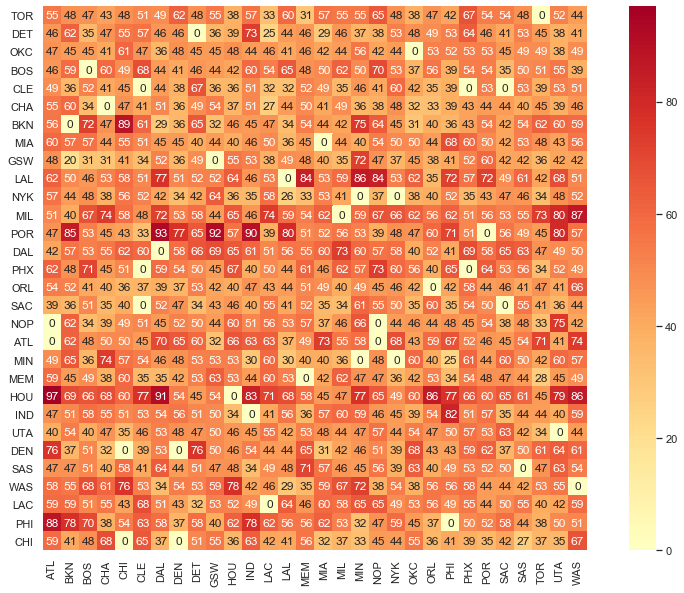

In [13]:
Crosstest=Cross.fillna(0)
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(data=Crosstest,annot=True,cmap='RdYlBu_r',center=True,square=True,cbar=True)

Cette Heatmap étant un peu trop dense ce qui la rend peu lisible on aimerait la réduire.
Ce qui tombe bien c'est que les équipes de même conférence se jouent plus que les équipes 
de conférences différentes, on refait cette Heatmap pour les Divisions East et West.

#### Séparation par conférence

In [17]:
Eastern=set(Stats[Stats['CONF']=='East']['TEAM'])
Western=set(Stats[Stats['CONF']=='West']['TEAM'])

In [30]:
Stats['Adv_East']=[Stats['ADV'][i] in Eastern for i in range(len(Stats))]
Adv_East=Stats[Stats['Adv_East']==True]
Adv_West=Stats[Stats['Adv_East']==False]

In [58]:
#Pour la conf Est
Cross_east=pd.DataFrame(columns=Eastern)
for team in Eastern:
    ligne=pd.DataFrame(Adv_East[Adv_East['TEAM']==team].groupby('ADV')['TTFL'].max())
    ligne=ligne.rename(columns={'TTFL':team})
    ligne=ligne.transpose()
    ligne[team]=0
    Cross_east=pd.concat([Cross_east,ligne])
    
#Pour la conf West
Cross_west=pd.DataFrame(columns=Western)
for team in Western:
    ligne=pd.DataFrame(Adv_West[Adv_West['TEAM']==team].groupby('ADV')['TTFL'].max())
    ligne=ligne.rename(columns={'TTFL':team})
    ligne=ligne.transpose()
    ligne[team]=0
    Cross_west=pd.concat([Cross_west,ligne])
    

C:\Users\veve1\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
C:\Users\veve1\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



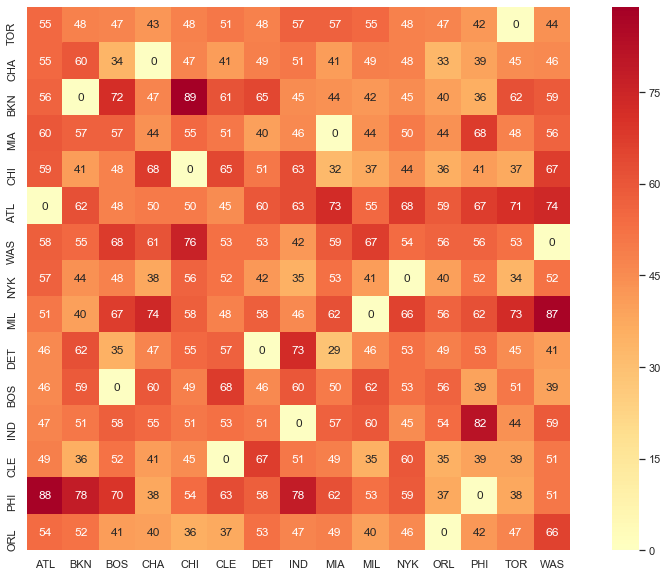

In [61]:
Cross_east=Cross_east.fillna(0)
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(data=Cross_east,annot=True,cmap='RdYlBu_r',center=True,square=True,cbar=True)

**Lecture:** Contre Atlanta, le meilleur score TTFL d'un joeur d'Orlando était 54

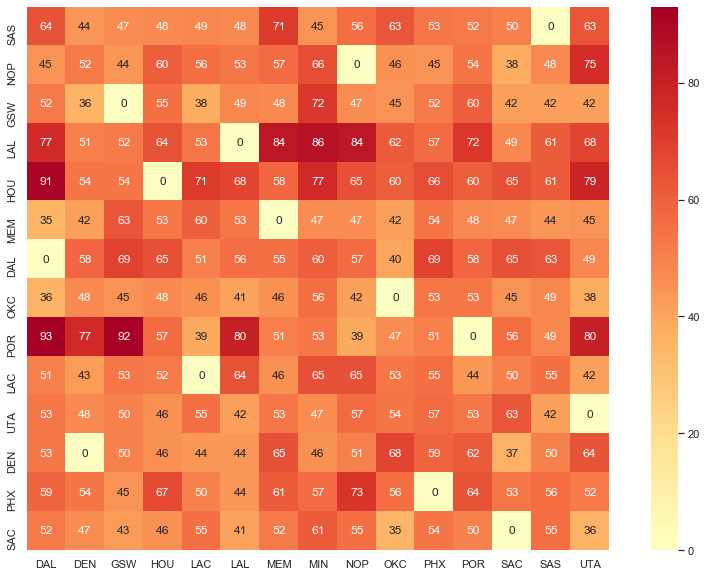

In [62]:
Cross_west=Cross_west.fillna(0)
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(data=Cross_west,annot=True,cmap='RdYlBu_r',center=True,square=True,cbar=True)

**Lecture:** Contre Dallas, le meilleur score TTFL d'un joeur de Sacramento était 52